In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers, Sequential, optimizers, Input, Model
from tensorflow.keras.layers import Dense, LeakyReLU
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
dataset = pd.read_csv(r'C:\Users\Indatech\Downloads\EMG\Dataset\EMG-data.csv', delimiter=',')

dataset=dataset.drop(columns=["time"])  #No necesitamos la columna del tiempo
dataset=dataset.drop(columns=["channel5"])  #Borra canal 5
dataset=dataset.drop(columns=["channel6"])  #Borra canal 6
dataset=dataset.drop(columns=["channel7"])  #Borra canal 7
dataset=dataset.drop(columns=["channel8"])  #Borra canal 8
dataset = dataset.drop(dataset[dataset["class"] == 0].index)
dataset = dataset.drop(dataset[dataset["class"] == 5].index)  #Borra Radial deviations
dataset = dataset.drop(dataset[dataset["class"] == 6].index)  #Borra Ulnar deviations
dataset = dataset.drop(dataset[dataset["class"] == 7].index)  #Borra Extended palm
dataset.to_csv("filtered_data.csv", index=False)

print(dataset.head())

print(dataset.shape)

      channel1  channel2  channel3  channel4  class  label
2287  -0.00001   0.00000  -0.00001   0.00000      1      1
2288  -0.00001  -0.00002   0.00000  -0.00001      1      1
2289  -0.00001  -0.00002   0.00000  -0.00001      1      1
2290  -0.00001  -0.00002   0.00000  -0.00001      1      1
2291  -0.00001  -0.00002   0.00000  -0.00001      1      1
(994312, 6)


In [3]:
features = dataset.drop(columns=["label","class"])  #CLASS son los gestos que se leen, LABELS son los sujetos haciendo los movimientos (hay 30+)
labels = dataset["class"]
features.head()  #ATTRIBUTES serian todas las señales detectadas

print(labels.unique())
print("Value Count :\n", labels.value_counts())
print("Shapes: ", features.shape, labels.shape)
print(type(labels))
print(type(features))

[1 2 3 4]
Value Count :
 class
4    251570
1    250055
3    249494
2    243193
Name: count, dtype: int64
Shapes:  (994312, 4) (994312,)


In [4]:
display(features.head())

#Pasa de series/dataframe a np.array
Class = labels.values
features = features.values

,channel1,channel2,channel3,channel4
2287,-0.00001,0.00000,-0.00001,0.00000
2288,-0.00001,-0.00002,0.00000,-0.00001
2289,-0.00001,-0.00002,0.00000,-0.00001
2290,-0.00001,-0.00002,0.00000,-0.00001
2291,-0.00001,-0.00002,0.00000,-0.00001


In [6]:
from sklearn.model_selection import train_test_split

# divide en variables de entrada (X) y salida (Y), entrena y prueba
x_train, x_test, y_train, y_test = train_test_split(features, Class, test_size=0.2, random_state=42)
print(x_train[:5])
print("Shapes: ", x_train.shape, x_test.shape, y_train.shape, y_test.shape)

[[-6.0e-05 -9.0e-05 -5.0e-05 -9.0e-05]
 [ 7.1e-04  3.2e-04  9.0e-05  3.2e-04]
 [-1.0e-05  1.0e-05  0.0e+00  1.0e-05]
 [ 0.0e+00  1.0e-05 -3.0e-05  1.3e-04]
 [-8.0e-05  1.0e-04 -3.0e-05  9.0e-05]]
Shapes:  (795449, 4) (198863, 4) (795449,) (198863,)


In [7]:
print(x_train.shape[1:])
print(y_train[:15])

(4,)
[4 2 1 4 2 2 1 4 2 3 2 2 4 1 4]


In [8]:
y_train_pre = y_train - 1   #TODAS LAS CLASES DISMINUYEN UN NUMERO
y_test_pre = y_test - 1

In [9]:
print(y_train[:15])

[4 2 1 4 2 2 1 4 2 3 2 2 4 1 4]


In [10]:
# NORMALIZANDO
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train -= mean
x_train /= std

x_test -= mean
x_test /= std

In [11]:
# codificacion one hot
y_train = tf.keras.utils.to_categorical(y_train_pre)
y_test = tf.keras.utils.to_categorical(y_test_pre)

In [12]:
print(x_train.shape[1:])
print(y_train)
print(len(np.unique(Class)))

(4,)
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
4


In [13]:
#ESTRUCTURA DEL MODELO
num_labels = len(np.unique(Class))

model = Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.Dense(512, activation='relu'))
# Capa 5: Capa de Dropout para reducir el sobreajuste (20% de las neuronas se apagan aleatoriamente)
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
# Capa de salida: Capa densa con un número de neuronas igual al número de clases
model.add(layers.Dense(num_labels, activation='softmax'))


opt = optimizers.Nadam(lr=1e-4)
model.compile(optimizer = opt,   #'Adam', #modificado para testear
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

# Muestra un resumen de la arquitectura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              5120      
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2

In [14]:
# guarda el modelo y crea un registro para tensorboard y ciertos callbacks utiles

def callbacks(Log,Dir):

  Filepath = Log
  logdir = os.path.join(Filepath, Dir)
  
  callbacks_list = [tf.keras.callbacks.TensorBoard(
                    log_dir=logdir,                      
                    histogram_freq=1,),
                    tf.keras.callbacks.EarlyStopping(   # detiene si deja de mejorar la presicion
                    monitor='val_accuracy',patience=4,),     # si se detiene, disminuye el learning rate
                    tf.keras.callbacks.ModelCheckpoint(
                    filepath= Filepath,             # guarda el modelo
                    monitor='val_loss',             # guarda los mejores pesos
                    save_best_only=True,)]
  return callbacks_list

In [15]:
Path = "model_tesis"
Dir = "my_log_dir"   
Call_B_Fun = callbacks(Path,Dir)

batch_size = 512            
epochs = 100                

#ENTRENANDO Y VALIDANDO
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs = epochs,
                    validation_split = 0.2, callbacks=Call_B_Fun)

#METRICAS CON EL CONJUNTO TOMADO DE VALIDACION
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#plot(loss,val_loss,acc,val_acc)

Epoch 1/100



1242/1243 [============================>.] - ETA: 0s - loss: 0.7450 - accuracy: 0.7007INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 55s 41ms/step - loss: 0.7451 - accuracy: 0.7007 - val_loss: 0.7134 - val_accuracy: 0.7103
Epoch 2/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.7186 - accuracy: 0.7112INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.7187 - accuracy: 0.7112 - val_loss: 0.7058 - val_accuracy: 0.7129
Epoch 3/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.7128 - accuracy: 0.7133INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 52s 42ms/step - loss: 0.7128 - accuracy: 0.7133 - val_loss: 0.7036 - val_accuracy: 0.7154
Epoch 4/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.7082 - accuracy: 0.7148INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 41ms/step - loss: 0.7082 - accuracy: 0.7148 - val_loss: 0.6975 - val_accuracy: 0.7184
Epoch 5/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.7039 - accuracy: 0.7166INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.7039 - accuracy: 0.7166 - val_loss: 0.6938 - val_accuracy: 0.7197
Epoch 6/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6997 - accuracy: 0.7186INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6997 - accuracy: 0.7185 - val_loss: 0.6913 - val_accuracy: 0.7204
Epoch 7/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6957 - accuracy: 0.7205INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 51s 41ms/step - loss: 0.6957 - accuracy: 0.7205 - val_loss: 0.6878 - val_accuracy: 0.7227
Epoch 8/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.7221INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 41ms/step - loss: 0.6919 - accuracy: 0.7221 - val_loss: 0.6832 - val_accuracy: 0.7241
Epoch 9/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.7241INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 41ms/step - loss: 0.6879 - accuracy: 0.7241 - val_loss: 0.6799 - val_accuracy: 0.7257
Epoch 10/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.7258INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6837 - accuracy: 0.7258 - val_loss: 0.6733 - val_accuracy: 0.7291
Epoch 11/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.7273INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6803 - accuracy: 0.7273 - val_loss: 0.6693 - val_accuracy: 0.7301
Epoch 12/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.7290INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6766 - accuracy: 0.7290 - val_loss: 0.6650 - val_accuracy: 0.7329
Epoch 13/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6727 - accuracy: 0.7307INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6728 - accuracy: 0.7307 - val_loss: 0.6594 - val_accuracy: 0.7361
Epoch 14/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.7325INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.6690 - accuracy: 0.7325 - val_loss: 0.6570 - val_accuracy: 0.7386
Epoch 15/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.7339INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 51s 41ms/step - loss: 0.6653 - accuracy: 0.7339 - val_loss: 0.6525 - val_accuracy: 0.7379
Epoch 16/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6620 - accuracy: 0.7353INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6620 - accuracy: 0.7353 - val_loss: 0.6486 - val_accuracy: 0.7403
Epoch 17/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.7369INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6587 - accuracy: 0.7369 - val_loss: 0.6416 - val_accuracy: 0.7446
Epoch 18/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.7387INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6556 - accuracy: 0.7387 - val_loss: 0.6374 - val_accuracy: 0.7449
Epoch 19/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.7399INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6517 - accuracy: 0.7399 - val_loss: 0.6362 - val_accuracy: 0.7462
Epoch 20/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6491 - accuracy: 0.7412INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 41ms/step - loss: 0.6491 - accuracy: 0.7412 - val_loss: 0.6282 - val_accuracy: 0.7495
Epoch 21/100
1243/1243 [==============================] - 49s 39ms/step - loss: 0.6465 - accuracy: 0.7428 - val_loss: 0.6287 - val_accuracy: 0.7502
Epoch 22/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.7434INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6435 - accuracy: 0.7434 - val_loss: 0.6221 - val_accuracy: 0.7528
Epoch 23/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6408 - accuracy: 0.7450INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6407 - accuracy: 0.7451 - val_loss: 0.6177 - val_accuracy: 0.7540
Epoch 24/100
1243/1243 [==============================] - 49s 39ms/step - loss: 0.6378 - accuracy: 0.7466 - val_loss: 0.6179 - val_accuracy: 0.7556
Epoch 25/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6350 - accuracy: 0.7475INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6350 - accuracy: 0.7475 - val_loss: 0.6117 - val_accuracy: 0.7584
Epoch 26/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6326 - accuracy: 0.7480INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6326 - accuracy: 0.7480 - val_loss: 0.6066 - val_accuracy: 0.7605
Epoch 27/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.7498INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6307 - accuracy: 0.7498 - val_loss: 0.6044 - val_accuracy: 0.7624
Epoch 28/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6280 - accuracy: 0.7508INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 41ms/step - loss: 0.6280 - accuracy: 0.7507 - val_loss: 0.6005 - val_accuracy: 0.7632
Epoch 29/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.7518INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 51s 41ms/step - loss: 0.6257 - accuracy: 0.7518 - val_loss: 0.5986 - val_accuracy: 0.7645
Epoch 30/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6239 - accuracy: 0.7522INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6238 - accuracy: 0.7523 - val_loss: 0.5961 - val_accuracy: 0.7645
Epoch 31/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 0.7533INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6210 - accuracy: 0.7533 - val_loss: 0.5911 - val_accuracy: 0.7678
Epoch 32/100
1243/1243 [==============================] - 49s 39ms/step - loss: 0.6199 - accuracy: 0.7540 - val_loss: 0.5918 - val_accuracy: 0.7659
Epoch 33/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6175 - accuracy: 0.7551INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6175 - accuracy: 0.7551 - val_loss: 0.5862 - val_accuracy: 0.7701
Epoch 34/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.7565INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6151 - accuracy: 0.7565 - val_loss: 0.5828 - val_accuracy: 0.7706
Epoch 35/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.7569INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6129 - accuracy: 0.7569 - val_loss: 0.5816 - val_accuracy: 0.7709
Epoch 36/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6119 - accuracy: 0.7576INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6119 - accuracy: 0.7576 - val_loss: 0.5773 - val_accuracy: 0.7736
Epoch 37/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.7583INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6099 - accuracy: 0.7583 - val_loss: 0.5766 - val_accuracy: 0.7750
Epoch 38/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.7591INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6081 - accuracy: 0.7591 - val_loss: 0.5718 - val_accuracy: 0.7764
Epoch 39/100
1243/1243 [==============================] - 48s 39ms/step - loss: 0.6060 - accuracy: 0.7601 - val_loss: 0.5725 - val_accuracy: 0.7750
Epoch 40/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6037 - accuracy: 0.7613INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6037 - accuracy: 0.7613 - val_loss: 0.5668 - val_accuracy: 0.7777
Epoch 41/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.7615INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6028 - accuracy: 0.7615 - val_loss: 0.5650 - val_accuracy: 0.7797
Epoch 42/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.6006 - accuracy: 0.7627INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6006 - accuracy: 0.7627 - val_loss: 0.5635 - val_accuracy: 0.7818
Epoch 43/100
1243/1243 [==============================] - ETA: 0s - loss: 0.6000 - accuracy: 0.7629INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.6000 - accuracy: 0.7629 - val_loss: 0.5598 - val_accuracy: 0.7833
Epoch 44/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5977 - accuracy: 0.7641INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5977 - accuracy: 0.7641 - val_loss: 0.5577 - val_accuracy: 0.7827
Epoch 45/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5962 - accuracy: 0.7644INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 53s 43ms/step - loss: 0.5961 - accuracy: 0.7644 - val_loss: 0.5562 - val_accuracy: 0.7842
Epoch 46/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.7651INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 51s 41ms/step - loss: 0.5947 - accuracy: 0.7651 - val_loss: 0.5547 - val_accuracy: 0.7847
Epoch 47/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5933 - accuracy: 0.7660INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5933 - accuracy: 0.7660 - val_loss: 0.5521 - val_accuracy: 0.7847
Epoch 48/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5916 - accuracy: 0.7673INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5916 - accuracy: 0.7673 - val_loss: 0.5492 - val_accuracy: 0.7869
Epoch 49/100
1243/1243 [==============================] - 49s 39ms/step - loss: 0.5914 - accuracy: 0.7667 - val_loss: 0.5493 - val_accuracy: 0.7869
Epoch 50/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.7683INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5890 - accuracy: 0.7683 - val_loss: 0.5469 - val_accuracy: 0.7893
Epoch 51/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5876 - accuracy: 0.7688INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 41ms/step - loss: 0.5876 - accuracy: 0.7688 - val_loss: 0.5452 - val_accuracy: 0.7884
Epoch 52/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.7692INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 52s 42ms/step - loss: 0.5858 - accuracy: 0.7692 - val_loss: 0.5410 - val_accuracy: 0.7927
Epoch 53/100
1243/1243 [==============================] - 49s 39ms/step - loss: 0.5852 - accuracy: 0.7695 - val_loss: 0.5427 - val_accuracy: 0.7897
Epoch 54/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5838 - accuracy: 0.7701INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5838 - accuracy: 0.7701 - val_loss: 0.5376 - val_accuracy: 0.7936
Epoch 55/100
1243/1243 [==============================] - 48s 39ms/step - loss: 0.5825 - accuracy: 0.7708 - val_loss: 0.5387 - val_accuracy: 0.7942
Epoch 56/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.7714INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 39ms/step - loss: 0.5813 - accuracy: 0.7714 - val_loss: 0.5360 - val_accuracy: 0.7948
Epoch 57/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.7719INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 51s 41ms/step - loss: 0.5799 - accuracy: 0.7719 - val_loss: 0.5330 - val_accuracy: 0.7947
Epoch 58/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5792 - accuracy: 0.7720INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5792 - accuracy: 0.7720 - val_loss: 0.5328 - val_accuracy: 0.7949
Epoch 59/100
1243/1243 [==============================] - 49s 39ms/step - loss: 0.5773 - accuracy: 0.7727 - val_loss: 0.5332 - val_accuracy: 0.7948
Epoch 60/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.7737INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5766 - accuracy: 0.7737 - val_loss: 0.5294 - val_accuracy: 0.7949
Epoch 61/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5749 - accuracy: 0.7740INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5749 - accuracy: 0.7739 - val_loss: 0.5265 - val_accuracy: 0.7979
Epoch 62/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.7755INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5733 - accuracy: 0.7755 - val_loss: 0.5238 - val_accuracy: 0.7990
Epoch 63/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5730 - accuracy: 0.7752INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5730 - accuracy: 0.7752 - val_loss: 0.5227 - val_accuracy: 0.7999
Epoch 64/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5715 - accuracy: 0.7761INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5715 - accuracy: 0.7761 - val_loss: 0.5215 - val_accuracy: 0.7998
Epoch 65/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.7761INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 39ms/step - loss: 0.5704 - accuracy: 0.7761 - val_loss: 0.5210 - val_accuracy: 0.8017
Epoch 66/100
1243/1243 [==============================] - 47s 38ms/step - loss: 0.5702 - accuracy: 0.7764 - val_loss: 0.5218 - val_accuracy: 0.8006
Epoch 67/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.7770INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 39ms/step - loss: 0.5693 - accuracy: 0.7770 - val_loss: 0.5198 - val_accuracy: 0.8031
Epoch 68/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5669 - accuracy: 0.7775INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5669 - accuracy: 0.7775 - val_loss: 0.5149 - val_accuracy: 0.8027
Epoch 69/100
1243/1243 [==============================] - 48s 39ms/step - loss: 0.5662 - accuracy: 0.7779 - val_loss: 0.5168 - val_accuracy: 0.8025
Epoch 70/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5660 - accuracy: 0.7786INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5660 - accuracy: 0.7786 - val_loss: 0.5147 - val_accuracy: 0.8044
Epoch 71/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5643 - accuracy: 0.7791INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5644 - accuracy: 0.7791 - val_loss: 0.5127 - val_accuracy: 0.8055
Epoch 72/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7798INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5631 - accuracy: 0.7798 - val_loss: 0.5101 - val_accuracy: 0.8055
Epoch 73/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7805INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5625 - accuracy: 0.7805 - val_loss: 0.5092 - val_accuracy: 0.8055
Epoch 74/100
1243/1243 [==============================] - 48s 38ms/step - loss: 0.5614 - accuracy: 0.7803 - val_loss: 0.5106 - val_accuracy: 0.8055
Epoch 75/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.7815INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 39ms/step - loss: 0.5600 - accuracy: 0.7815 - val_loss: 0.5087 - val_accuracy: 0.8056
Epoch 76/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.7809INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5600 - accuracy: 0.7809 - val_loss: 0.5069 - val_accuracy: 0.8076
Epoch 77/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5583 - accuracy: 0.7821INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5584 - accuracy: 0.7820 - val_loss: 0.5029 - val_accuracy: 0.8092
Epoch 78/100
1243/1243 [==============================] - 48s 39ms/step - loss: 0.5580 - accuracy: 0.7818 - val_loss: 0.5036 - val_accuracy: 0.8088
Epoch 79/100
1243/1243 [==============================] - 48s 38ms/step - loss: 0.5580 - accuracy: 0.7820 - val_loss: 0.5045 - val_accuracy: 0.8084
Epoch 80/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.7826INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5566 - accuracy: 0.7826 - val_loss: 0.5009 - val_accuracy: 0.8096
Epoch 81/100
1243/1243 [==============================] - 48s 39ms/step - loss: 0.5553 - accuracy: 0.7833 - val_loss: 0.5017 - val_accuracy: 0.8103
Epoch 82/100
1243/1243 [==============================] - 48s 39ms/step - loss: 0.5537 - accuracy: 0.7838 - val_loss: 0.5011 - val_accuracy: 0.8101
Epoch 83/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.7838INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5533 - accuracy: 0.7838 - val_loss: 0.4974 - val_accuracy: 0.8134
Epoch 84/100
1243/1243 [==============================] - 48s 38ms/step - loss: 0.5528 - accuracy: 0.7843 - val_loss: 0.4981 - val_accuracy: 0.8116
Epoch 85/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5518 - accuracy: 0.7849INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 39ms/step - loss: 0.5519 - accuracy: 0.7849 - val_loss: 0.4929 - val_accuracy: 0.8149
Epoch 86/100
1243/1243 [==============================] - 48s 39ms/step - loss: 0.5508 - accuracy: 0.7853 - val_loss: 0.4967 - val_accuracy: 0.8117
Epoch 87/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5500 - accuracy: 0.7856INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5499 - accuracy: 0.7856 - val_loss: 0.4917 - val_accuracy: 0.8157
Epoch 88/100
1243/1243 [==============================] - 48s 39ms/step - loss: 0.5502 - accuracy: 0.7856 - val_loss: 0.4955 - val_accuracy: 0.8129
Epoch 89/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5480 - accuracy: 0.7867INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 50s 40ms/step - loss: 0.5480 - accuracy: 0.7867 - val_loss: 0.4909 - val_accuracy: 0.8166
Epoch 90/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5480 - accuracy: 0.7866INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 49s 40ms/step - loss: 0.5480 - accuracy: 0.7866 - val_loss: 0.4864 - val_accuracy: 0.8172
Epoch 91/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.7867INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 1982s 2s/step - loss: 0.5473 - accuracy: 0.7867 - val_loss: 0.4862 - val_accuracy: 0.8166
Epoch 92/100
1243/1243 [==============================] - 55s 44ms/step - loss: 0.5469 - accuracy: 0.7872 - val_loss: 0.4884 - val_accuracy: 0.8169
Epoch 93/100
1243/1243 [==============================] - 54s 43ms/step - loss: 0.5455 - accuracy: 0.7881 - val_loss: 0.4869 - val_accuracy: 0.8174
Epoch 94/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5450 - accuracy: 0.7886INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 55s 44ms/step - loss: 0.5450 - accuracy: 0.7886 - val_loss: 0.4849 - val_accuracy: 0.8191
Epoch 95/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7888INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 55s 44ms/step - loss: 0.5437 - accuracy: 0.7888 - val_loss: 0.4820 - val_accuracy: 0.8188
Epoch 96/100
1243/1243 [==============================] - 54s 43ms/step - loss: 0.5431 - accuracy: 0.7891 - val_loss: 0.4855 - val_accuracy: 0.8180
Epoch 97/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.7897INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 55s 44ms/step - loss: 0.5416 - accuracy: 0.7897 - val_loss: 0.4815 - val_accuracy: 0.8185
Epoch 98/100
1242/1243 [============================>.] - ETA: 0s - loss: 0.5418 - accuracy: 0.7895INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 55s 44ms/step - loss: 0.5418 - accuracy: 0.7895 - val_loss: 0.4800 - val_accuracy: 0.8201
Epoch 99/100
1243/1243 [==============================] - 54s 43ms/step - loss: 0.5403 - accuracy: 0.7904 - val_loss: 0.4809 - val_accuracy: 0.8200
Epoch 100/100
1243/1243 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7911INFO:tensorflow:Assets written to: model_tesis\assets


INFO:tensorflow:Assets written to: model_tesis\assets


1243/1243 [==============================] - 55s 44ms/step - loss: 0.5391 - accuracy: 0.7911 - val_loss: 0.4790 - val_accuracy: 0.8199


In [17]:
evaluation = model.evaluate(x_test,  y_test,batch_size=batch_size, verbose=2)
print()
print("Test loss :",evaluation[0]*100,"%")
print("Test accuracy :",evaluation[1]*100,"%")
print( model.metrics_names) #a ver si puede sacarse el f1 directo de acá

389/389 - 4s - loss: 0.4811 - accuracy: 0.8184 - 4s/epoch - 10ms/step

Test loss : 48.10808002948761 %
Test accuracy : 81.84328079223633 %
['loss', 'accuracy']


In [18]:
predicted_y = model.predict(x_test)
predicted_y_pre = predicted_y
print(predicted_y[:5])

6215/6215 [==============================] - 18s 3ms/step
[[7.1243542e-01 3.6099292e-02 1.3127770e-01 1.2018756e-01]
 [1.3914869e-04 7.7875257e-02 3.4174162e-01 5.8024400e-01]
 [9.1072589e-01 1.5601973e-02 4.9497657e-02 2.4174461e-02]
 [4.2157714e-07 7.8461193e-02 9.1993767e-01 1.6007057e-03]
 [5.2424171e-04 1.4389628e-01 8.0290788e-01 5.2671678e-02]]


In [19]:
j = 0
for i in predicted_y:
  i = np.argmax(i)
  for m in range(len(predicted_y[j])):
    if m == i:
      predicted_y[j][m] = 1.
    else:
      predicted_y[j][m] = 0.
  if j < 5:
    print(i)
  j = j+1

print(predicted_y[:5])
print(y_test[:5])

0
3
0
2
2
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [20]:
from sklearn.metrics import accuracy_score, f1_score

# calculate F1 score
f1_test = f1_score(y_test, predicted_y, average='weighted')

print("Test F1 Score:", f1_test)

Test F1 Score: 0.8150262631976514


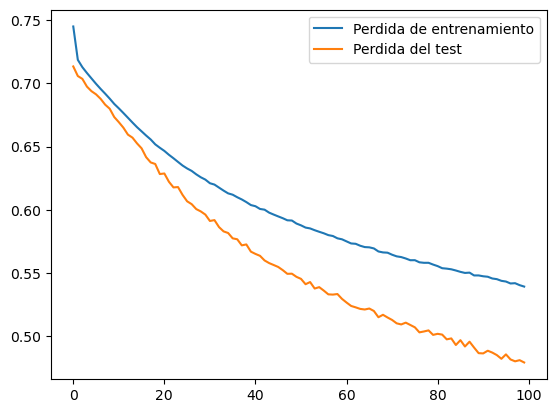

In [21]:
# Entrenamiento y prueba del gráfico de pérdidas
plt.plot(history.history['loss'], label='Perdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida del test')
plt.legend()
plt.show()

In [22]:
print(predicted_y[:5])
print(y_test[:5])

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

x=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y, axis=1))  #Los argumentos aqui son np.arrays
print(x)

[[47382   462   841  1248]
 [ 2455 32109  7156  7162]
 [ 3651  3643 41013  1238]
 [ 3663  3130  1458 42252]]


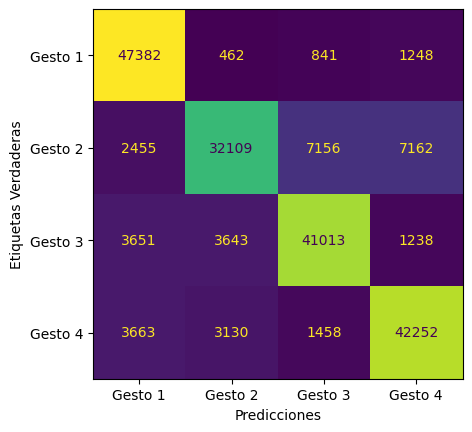

In [26]:
#Generamos la matriz de confusion
labels = ['Gesto 1', 'Gesto 2', 'Gesto 3', 'Gesto 4'] # Etiquetas correctas para las clases
cm_display = ConfusionMatrixDisplay(confusion_matrix = x, display_labels=labels)

cm_display.plot(colorbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()

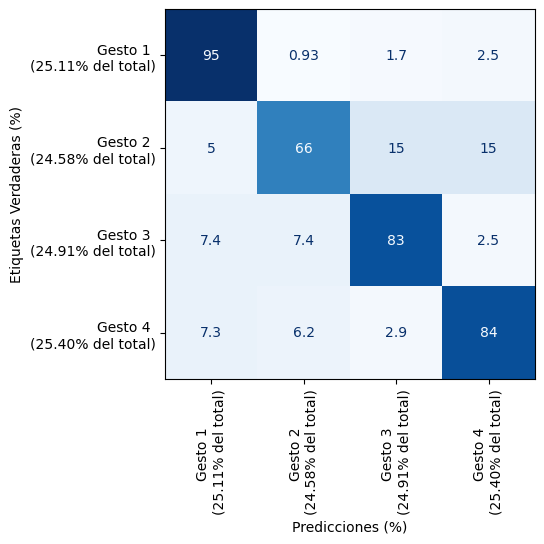

In [27]:
# Normaliza la matriz de confusión para obtener porcentajes
cm_norm = x.astype('float') / x.sum(axis=1)[:, np.newaxis] * 100

# Calcular la suma de cada fila para obtener el número total de predicciones para cada clase
total_predictions_per_class = x.sum(axis=1)

# Calcular el porcentaje que representa cada fila en la cantidad total de datos del conjunto
total_data = total_predictions_per_class.sum()
percentages_per_class = (total_predictions_per_class / total_data) * 100

# Crear una lista de etiquetas con los porcentajes
labels_with_percentages = [f'{label} \n({percent:.2f}% del total)' for label, percent in zip(labels, percentages_per_class)]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels_with_percentages)

cm_display.plot(cmap='Blues',xticks_rotation='vertical', colorbar=False)  # Lo colocamos azul para distinguir

plt.xlabel('Predicciones (%)')
plt.ylabel('Etiquetas Verdaderas (%)')


plt.show()

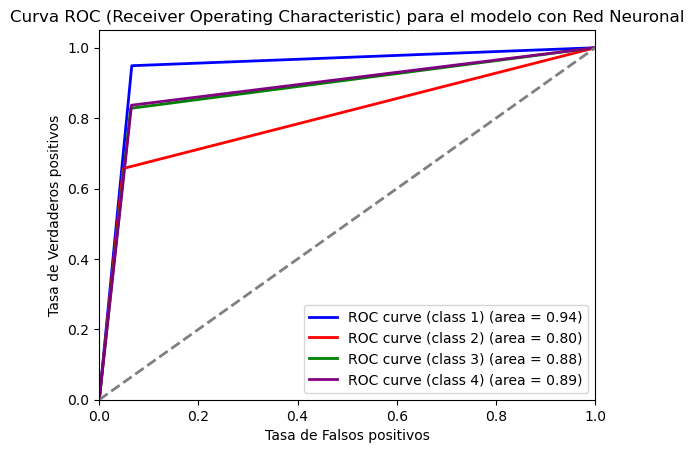

In [29]:
#PLOTEA LA CURVA ROC DE LA MATRIZ DE CONFUSION
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

test_y_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
predictions_onehot= label_binarize(predicted_y, classes=[1, 2, 3, 4])

for i in range(4):  # 4 clases o gestos para clasificars
    fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], predictions_onehot[:, i])  # Suponiendo que 'y_true' y 'y_scores' son matrices con forma (n_samples, num_classes)    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotea curva ROC para cada clase
plt.figure()
colors = ['blue', 'red', 'green', 'purple']  # Ajusta colores
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (class {0}) (area = {1:0.2f})'.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
plt.title('Curva ROC (Receiver Operating Characteristic) para el modelo con Red Neuronal')
plt.legend(loc="lower right")
plt.show()

In [30]:
#AHORA PREDICIENDO DE FORMA INDIVIDUAL
predict = 124
a = np.argmax(model.predict(x_test)[predict])
print("Predicted Class: ",a)
print("Actual Class: ",np.argmax(y_test[predict]))

6215/6215 [==============================] - 22s 4ms/step
Predicted Class:  2
Actual Class:  2
